In [3250]:
import os
import csv
import sys
import copy
import time
import logging
import datetime
import numpy as np
#from stats import *
import pandas as pd
import seaborn as sns
from scipy import stats
#from Layer import Layer
import tensorflow as tf 
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_california_housing, make_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3251]:
def write_stats(samples, features, loss, epochs, lr, batch_size, cross_k, r2, mse_train, mae_train, residual_train):
    with open('../data/stats.csv', 'a') as f:
        newrow = [samples, features, loss, epochs, lr, batch_size, cross_k, r2, mse_train, mae_train, residual_train]
        writer = csv.writer(f)
        writer.writerow(newrow)

def fill_dataset(dataframe: DataFrame):
    for column in dataframe:
        if dataframe[column].dtype != 'object':
            dataframe[column] = dataframe[column].fillna(dataframe[column].mean())
    return dataframe

def normalize_dataset(X):
    return tf.keras.utils.normalize(X)

def remove_outliers(X, threshold=7):
    z = np.abs(stats.zscore(X))
    return X[(z<threshold).all(axis=1)][:, 0:-1], X[(z<threshold).all(axis=1)][: ,-1]

def make_dataset(X_data,y_data,k):
    X_data, y_data = remove_outliers(np.concatenate([X_data, y_data], axis=1))
    def gen():
        for train_index, test_index in KFold(k).split(X_data):
            X_train, X_test = X_data[train_index], X_data[test_index]
            XN_train, XN_test = normalize_dataset(X_data[train_index]), normalize_dataset(X_data[test_index])
            y_train, y_test = y_data[train_index], y_data[test_index]
            yield X_train,XN_train,y_train,X_test,XN_test,y_test

    return tf.data.Dataset.from_generator(gen, (tf.double,tf.double,tf.double,tf.double,tf.double,tf.double))


In [3252]:
total_columns=["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
k = 2
batch_size = 120

#XR, yR = make_regression(n_samples=1000, n_features=2, n_informative=5, noise=50, random_state=5)
#X_train, X_test, y_train, y_test = train_test_split(XR, yR, test_size=0.20, random_state=2)
#columns = ["{0}".format(total_columns[i]) for i in range(XR.shape[1]+1)]
#dataframe = pd.DataFrame(np.concatenate([XR, np.reshape(yR, [-1, 1])], axis=1), columns=columns)

stocks = pd.read_csv("../data/datasets/all_stocks_5yr.csv")
stocks = pd.DataFrame(stocks)
filter = stocks["Name"]=="AAPL"
stocks = stocks.where(filter).dropna()
stocks.drop(['Name', "date"], axis=1, inplace=True)
stocks['target'] = stocks['close'].fillna(stocks['close'].mean())
#data['type'] = 1 if dataframe['open']-dataframe['close']>=0 else 0
rnnstocks = stocks.values[0:100, :]
n_features = len(rnnstocks[0])
n_rows = 10
n_ciclics = 10
data = np.array(rnnstocks).reshape(n_ciclics, n_rows, n_features)
X = data[:, 0:-1, :]
Y = data[:, -1, :]

stocks.head()

,open,high,low,close,volume,target
1259,67.7142,68.4014,66.8928,67.8542,158168416.0,67.8542
1260,68.0714,69.2771,67.6071,68.5614,129029425.0,68.5614
1261,68.5014,68.9114,66.8205,66.8428,151829363.0,66.8428
1262,66.7442,67.6628,66.1742,66.7156,118721995.0,66.7156
1263,66.3599,67.3771,66.2885,66.6556,88809154.0,66.6556


In [3253]:
vif_data = pd.DataFrame()
vif_data["features"] = stocks.columns
vif_data["VIF"] = [variance_inflation_factor(stocks.values, i) for i in range(len(stocks.columns))]
print(vif_data)

  features           VIF
0     open  3.872826e+04
1     high  5.060050e+04
2      low  4.511802e+04
3    close           inf
4   volume  2.630125e+00
5   target           inf


C:\Users\Utente\AppData\Roaming\Python\Python39\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [3254]:
class DenseLayer(tf.Module):
    def __init__(self, n_neurons, input_dim, activation=tf.identity, dropout=0.0):
        self.n_neurons = n_neurons
        self.input_dim = input_dim
        self.builded = False
        self.activation = activation
        self.dropout = dropout
    
    @tf.function
    def build(self):
        if not self.builded:
            self.W_n = tf.Variable(tf.random.uniform(shape=(self.n_neurons, self.input_dim)), dtype=tf.float32, trainable=True)
            self.bias = tf.Variable(tf.ones(shape=(self.n_neurons)), dtype=tf.float32, trainable=True)
            self.vars = [self.W_n, self.bias]
            self.builded = True
            
    @tf.function(reduce_retracing=True)
    def __call__(self, X):
        print("------DenseLayer------")
        hypotesis = tf.transpose(tf.add(tf.transpose(tf.multiply(self.W_n, X)), self.bias))
        output = tf.nn.dropout(self.activation(hypotesis), self.dropout)
        
        print("[#] output: {0}".format(output.shape))
        print("\n")
        return output

In [3255]:
class LSTMLayer(tf.Module):
    def __init__(self, units, input_dim, output_dim):
        self.units = units
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.builded = False   

    @tf.function
    def build(self):
        if not self.builded:
            self.W_hx = tf.Variable(tf.eye(self.units, self.input_dim), trainable=True, dtype=tf.float32)
            self.W_hh = tf.Variable(tf.eye(self.units, self.units), trainable=True, dtype=tf.float32)
            self.W_hy = tf.Variable(tf.eye(self.input_dim, self.units), trainable=True, dtype=tf.float32)
            self.h = tf.Variable(tf.zeros([self.units, 1]), dtype=tf.float32)
            self.vars = [self.W_hx, self.W_hh, self.W_hy]
            self.builded = True

    @tf.function(reduce_retracing=True)
    def __call__(self, x):
        print("------LSTMLayer------")
        print("[#] W_hx: {0}, W_hh: {1}, W_hy: {2}, X: {3}".format(self.W_hx.shape, self.W_hh.shape, self.W_hy.shape, x.shape))
        updated_input = tf.matmul(self.W_hx, x, transpose_b=True)
        updated_memory = tf.matmul(self.W_hh, self.h)
        print("[#] updated_input: {0}, updated_memory: {1}".format(updated_input.shape, updated_memory.shape))
        self.h = tf.math.tanh(
            tf.add(updated_memory, updated_input), 
        )
        output = tf.reduce_sum(tf.nn.sigmoid(tf.matmul(self.W_hy, self.h)), axis=1)
        print("[#] h: {0}, output: {1}".format(self.h.shape, output.shape))
        print("\n")
        return output, self.h
    

In [3256]:
class MarketAI(tf.Module):
    def __init__(self, layers, epochs=100, lr=0.1, l1=0.1, l2=0.1):
        super().__init__(name="MarketAI")
        self.epochs = epochs+1
        self.layers = layers
        self.l1 = tf.convert_to_tensor(l1, dtype=tf.float32)
        self.l2 = tf.convert_to_tensor(l2, dtype=tf.float32)
        self.Adam = tf.optimizers.Adam(lr)
        self.loss_history = [e for e in range(self.epochs)]
        self.r2_history = [e for e in range(self.epochs)]
        self.losses = [e for e in range(len(self.layers))]
        self.losses_test = [e for e in range(len(self.layers))]
        self._builded = False

    def _history(self, e, loss, y, y_pred):
        self.loss_history[e] = loss
        self.r2_history[e] = self._r2(y, y_pred)

    def load(self, X_train, X_test):
        self.X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        self.X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        self.X_train_norm = tf.cast(tf.keras.utils.normalize(X_train), dtype=tf.float32)
        self.X_test_norm = tf.cast(tf.keras.utils.normalize(X_test), dtype=tf.float32)

    @tf.function
    def build(self):
        for l in range(len(self.layers)):
            self.layers[l].build()

    def _r2(self, y, y_pred):
        return tf.reduce_mean(tf.subtract(
            tf.convert_to_tensor(1, dtype=tf.float32), 
            tf.divide(
                tf.reduce_sum(tf.square(tf.subtract(y, y_pred))),
                tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y_pred))))
            )
        ))
    
    @tf.function
    def _lasso(self, weights):
        return tf.reduce_sum(tf.multiply(self.l1, tf.abs(weights)))

    @tf.function
    def _ridge(self, weights):
        return tf.reduce_sum(1/2*tf.multiply(self.l2, tf.square(weights)))

    @tf.function
    def _loss(self, y, predicted, weights):
        lasso_reg = tf.reduce_sum([self._lasso(weight) for weight in weights])
        ridge_reg = tf.reduce_sum([self._ridge(weight) for weight in weights])
        
        return tf.add(tf.add(tf.losses.MSE(y, predicted), lasso_reg), ridge_reg)    

    def _forward_lstm_layer(self, i, X_loss, output):
        outputs = []
        losses = []
        for x_loss, x in zip(X_loss, tf.reshape(output, [output.shape[1], output.shape[0], output.shape[2]])):
            loss, output = self._forward_lstm(i, x, x_loss)
            losses.append(loss)
            outputs.append(output)
        loss = tf.reduce_sum(losses)
        return loss, outputs

    @tf.function
    def _forward_lstm(self, i, x, x_loss):
        output, h = self.layers[i](x)
        loss = self._loss(x_loss, output, [self.layers[i].W_hx, self.layers[i].W_hh, self.layers[i].W_hy])
        return loss, tf.convert_to_tensor(output, dtype=tf.float32)
    
    def _forward_dense_layer(self, i, X_loss, X_norm):
        outputs = []
        losses = []
        for x, x_loss in zip(X_loss, X_norm):
            loss, output = self._forward_dense(i, x, x_loss)
            losses.append(loss)
            outputs.append(output)
        loss = tf.reduce_sum(losses)
        return loss, tf.convert_to_tensor(outputs, dtype=tf.float32)

    @tf.function
    def _forward_dense(self, i, x, x_loss):
        output = self.layers[i](x)
        loss = self._loss(x_loss, output, [self.layers[i].W_n])
        return loss, output

    def predict(self):
        self.predicted_test, self.final_loss_test = self._forward(self.X_test, self.X_test_norm)
        
    def _forward(self, X, X_norm):
        losses = [e for e in range(len(self.layers))]
        losses[0], output = self._forward_dense_layer(0, X, X_norm)
        losses[1], output = self._forward_lstm_layer(1, X, output)
        losses[2], output = self._forward_dense_layer(2, X, output)
        losses[3], output = self._forward_dense_layer(3, X, output)
        predicted = tf.reduce_mean(tf.reshape(output, [output.shape[1], output.shape[0], output.shape[2]]), axis=1)
        final_loss = tf.reduce_sum(self.losses)
        return predicted, final_loss

    def _backprop(self, tape: tf.GradientTape):
        grads = tape.gradient(self.final_loss, self.variables) 
        self.Adam.apply_gradients(zip(grads, self.variables))

    def train(self):
        for e in range(self.epochs):
            with tf.GradientTape(watch_accessed_variables=True, persistent=True) as tape:
                self.predicted_train, self.final_loss = self._forward(self.X_train, self.X_train_norm)
            self._backprop(tape)

            self._history(e, self.final_loss, self.X_train, self.predicted_train)
            if e%500==0 or e == 0:
                print("[{6}] Loss0: {0}, Loss1: {1}, Loss2: {2}, Loss3: {5}, TotalLoss: {3} R2: {4}".format(self.losses[0], self.losses[1], self.losses[2], self.final_loss, self.r2_history[e], self.losses[3], e))

In [3257]:
n_ciclic, n_rows, n_features = X.shape
n_neurons = 50
epochs = 1000
lr = 0.02
l1, l2 = 0.01, 0.01
model = MarketAI([
    DenseLayer(n_neurons, n_features, activation=tf.nn.relu, dropout=0.0),
    LSTMLayer(n_neurons, n_features, 1),
    DenseLayer(n_neurons, n_features, activation=tf.nn.relu, dropout=0.0),
    DenseLayer(1, n_features),
], epochs, lr, l1, l2)
model.build()
model.load(X[0], X[1])
model.train()
model.predict()

------DenseLayer------
[#] output: (50, 6)


------LSTMLayer------
[#] W_hx: (50, 6), W_hh: (50, 50), W_hy: (6, 50), X: (9, 6)
[#] updated_input: (50, 9), updated_memory: (50, 1)
[#] h: (50, 9), output: (6,)


------DenseLayer------
[#] output: (50, 6)


------DenseLayer------
[#] output: (1, 6)




ValueError: No gradients provided for any variable: (['Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'Variable:0' shape=(50, 6) dtype=float32, numpy=
array([[0.39972663, 0.23250222, 0.82776356, 0.9817622 , 0.5739337 ,
        0.752522  ],
       [0.587989  , 0.63420665, 0.74236727, 0.38493502, 0.15985191,
        0.56722474],
       [0.51093936, 0.48185682, 0.57098603, 0.44831586, 0.9537741 ,
        0.16868687],
       [0.7430154 , 0.5744529 , 0.17673767, 0.2256676 , 0.9987495 ,
        0.38166368],
       [0.44088483, 0.7932917 , 0.47164333, 0.72268856, 0.49782467,
        0.27124548],
       [0.86696196, 0.49537778, 0.55275035, 0.7056314 , 0.8152276 ,
        0.4435438 ],
       [0.9577888 , 0.9917215 , 0.18099773, 0.67040145, 0.85532534,
        0.4870025 ],
       [0.7526845 , 0.8546127 , 0.16036344, 0.9550797 , 0.6061764 ,
        0.8815248 ],
       [0.0654341 , 0.5600158 , 0.2412988 , 0.69867253, 0.3424207 ,
        0.7604886 ],
       [0.87243676, 0.86397505, 0.27317178, 0.46360004, 0.3857615 ,
        0.975     ],
       [0.66585684, 0.68307245, 0.481611  , 0.03452837, 0.21863985,
        0.64600897],
       [0.57404613, 0.65145516, 0.16631782, 0.29616845, 0.20242321,
        0.6239637 ],
       [0.37490797, 0.21531701, 0.2042489 , 0.29905295, 0.24894571,
        0.4041834 ],
       [0.16088319, 0.38887691, 0.8615712 , 0.04102194, 0.1088804 ,
        0.59985244],
       [0.36954534, 0.3734486 , 0.5918257 , 0.7214335 , 0.40778697,
        0.17525327],
       [0.3065312 , 0.58097196, 0.8592619 , 0.05715871, 0.8546779 ,
        0.39615357],
       [0.93730307, 0.04248381, 0.7871995 , 0.5684364 , 0.2627207 ,
        0.85811734],
       [0.71941745, 0.58124924, 0.957803  , 0.1111238 , 0.7019309 ,
        0.89810383],
       [0.43541288, 0.8321879 , 0.7372403 , 0.42972338, 0.4857322 ,
        0.5012138 ],
       [0.8968353 , 0.5272267 , 0.29031873, 0.6649201 , 0.01047719,
        0.2538036 ],
       [0.37037826, 0.32543576, 0.92549455, 0.64714766, 0.32493377,
        0.18409681],
       [0.50773084, 0.8687266 , 0.28808033, 0.29026413, 0.91101265,
        0.07960355],
       [0.20331025, 0.4667194 , 0.8740909 , 0.48866475, 0.32436872,
        0.4507475 ],
       [0.59122336, 0.7713572 , 0.4759401 , 0.8227414 , 0.5743034 ,
        0.6684557 ],
       [0.38748646, 0.86721826, 0.83958817, 0.5943737 , 0.5889038 ,
        0.43879175],
       [0.8736862 , 0.21599627, 0.5166092 , 0.4132656 , 0.30544782,
        0.053267  ],
       [0.98621905, 0.3047861 , 0.38769913, 0.00429857, 0.40951276,
        0.06705439],
       [0.42634082, 0.10303223, 0.87333405, 0.50915396, 0.38341796,
        0.6371906 ],
       [0.35734487, 0.05247939, 0.19122136, 0.9878731 , 0.38101065,
        0.9704131 ],
       [0.16122746, 0.74951804, 0.15927184, 0.41021895, 0.4268602 ,
        0.52880096],
       [0.08503962, 0.84939706, 0.7815392 , 0.6367024 , 0.9428109 ,
        0.7486417 ],
       [0.07000458, 0.2752924 , 0.13162863, 0.5068157 , 0.45557868,
        0.6105305 ],
       [0.8585272 , 0.96924865, 0.53969383, 0.97307086, 0.6729331 ,
        0.5580791 ],
       [0.08271122, 0.6308851 , 0.29370844, 0.31740367, 0.26332176,
        0.80619   ],
       [0.9217719 , 0.4431008 , 0.00318015, 0.9221935 , 0.4837774 ,
        0.55241334],
       [0.62865853, 0.02213717, 0.7346028 , 0.95128167, 0.8457532 ,
        0.41662097],
       [0.9047389 , 0.78526676, 0.73519826, 0.5574894 , 0.05048132,
        0.7276    ],
       [0.5091301 , 0.86855173, 0.6257062 , 0.51859725, 0.02939498,
        0.8798189 ],
       [0.13161647, 0.09960067, 0.5317857 , 0.71259046, 0.16265273,
        0.03137159],
       [0.4808519 , 0.01245117, 0.5183774 , 0.80825436, 0.98725617,
        0.5305071 ],
       [0.02239072, 0.7328603 , 0.43104053, 0.07228494, 0.16764462,
        0.49621534],
       [0.38443756, 0.30128586, 0.19264376, 0.48784566, 0.7693329 ,
        0.94594705],
       [0.18713212, 0.04516566, 0.5556488 , 0.9202597 , 0.632357  ,
        0.06015193],
       [0.69694614, 0.12870884, 0.28526282, 0.63836753, 0.31912076,
        0.76237285],
       [0.4516989 , 0.00350308, 0.4330839 , 0.97446597, 0.6756351 ,
        0.5037565 ],
       [0.9537798 , 0.1762774 , 0.42558908, 0.12102902, 0.35758948,
        0.90402496],
       [0.38931453, 0.29168785, 0.04980278, 0.28398454, 0.8741853 ,
        0.05690503],
       [0.00232172, 0.7329519 , 0.76053524, 0.9407681 , 0.19476342,
        0.13700712],
       [0.25138497, 0.61164856, 0.6486118 , 0.07923996, 0.5922729 ,
        0.07597852],
       [0.5587988 , 0.74860966, 0.47953165, 0.03410113, 0.2651862 ,
        0.5625038 ]], dtype=float32)>), (None, <tf.Variable 'Variable:0' shape=(50,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>), (None, <tf.Variable 'Variable:0' shape=(50, 50) dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>), (None, <tf.Variable 'Variable:0' shape=(50, 6) dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)>), (None, <tf.Variable 'Variable:0' shape=(6, 50) dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)>), (None, <tf.Variable 'Variable:0' shape=(50, 6) dtype=float32, numpy=
array([[0.08468688, 0.97575724, 0.44105923, 0.6899216 , 0.41546595,
        0.8721144 ],
       [0.77005494, 0.38678813, 0.3344127 , 0.20208275, 0.1578064 ,
        0.30831468],
       [0.27850187, 0.39183295, 0.38270688, 0.37304223, 0.6595458 ,
        0.05086923],
       [0.54390395, 0.08387256, 0.7985122 , 0.70095754, 0.7386842 ,
        0.6984916 ],
       [0.1162436 , 0.4274143 , 0.523435  , 0.7374326 , 0.8992765 ,
        0.13556206],
       [0.2907318 , 0.17027211, 0.9881195 , 0.862406  , 0.20139241,
        0.12526715],
       [0.4391576 , 0.9779717 , 0.06599891, 0.6849463 , 0.8121748 ,
        0.3970195 ],
       [0.67852044, 0.9666786 , 0.31795764, 0.19595218, 0.6730926 ,
        0.60733855],
       [0.95712197, 0.7651719 , 0.0237118 , 0.91389215, 0.67204595,
        0.9913254 ],
       [0.6275815 , 0.5840539 , 0.71088815, 0.98530054, 0.7337656 ,
        0.5477289 ],
       [0.08885646, 0.4391116 , 0.55861175, 0.68285   , 0.72316945,
        0.06287789],
       [0.93003714, 0.07593334, 0.33834755, 0.94492924, 0.0428766 ,
        0.86335194],
       [0.5978966 , 0.18363786, 0.92185426, 0.8163556 , 0.516366  ,
        0.8978301 ],
       [0.07641757, 0.957127  , 0.7314681 , 0.84676003, 0.08734643,
        0.83869743],
       [0.24592042, 0.1807288 , 0.5262283 , 0.53611004, 0.93067384,
        0.15490746],
       [0.5114353 , 0.6559768 , 0.39638865, 0.03724122, 0.58549416,
        0.30199146],
       [0.7822367 , 0.22107327, 0.2692964 , 0.39155555, 0.74758863,
        0.7587619 ],
       [0.46378565, 0.45998633, 0.44197786, 0.00901783, 0.07745588,
        0.309057  ],
       [0.26659143, 0.6814289 , 0.18925333, 0.22646046, 0.6678529 ,
        0.3820703 ],
       [0.58634794, 0.15732932, 0.5281724 , 0.8037211 , 0.62353075,
        0.30925083],
       [0.25260758, 0.3268646 , 0.04164279, 0.19375598, 0.3584684 ,
        0.21075428],
       [0.564757  , 0.12446415, 0.41139686, 0.59174263, 0.00334561,
        0.68780065],
       [0.94057715, 0.9634625 , 0.24089527, 0.41448224, 0.6028547 ,
        0.24175048],
       [0.7042029 , 0.67964137, 0.08558142, 0.7368201 , 0.05918467,
        0.74723864],
       [0.6656219 , 0.92964387, 0.72951555, 0.85360575, 0.49741805,
        0.9197866 ],
       [0.9416549 , 0.48991466, 0.98240125, 0.6057528 , 0.32966256,
        0.23181486],
       [0.6869347 , 0.8762082 , 0.98418486, 0.03953075, 0.03809631,
        0.17020738],
       [0.0126586 , 0.04927003, 0.39516377, 0.5849304 , 0.7335644 ,
        0.9431248 ],
       [0.6072769 , 0.35523963, 0.734449  , 0.44942427, 0.4328084 ,
        0.8827393 ],
       [0.12899446, 0.11739981, 0.84224653, 0.57548475, 0.83548975,
        0.5482557 ],
       [0.9833163 , 0.6990801 , 0.2576369 , 0.15591633, 0.5413548 ,
        0.45506012],
       [0.35829842, 0.47503257, 0.5543666 , 0.30840862, 0.60667336,
        0.12467957],
       [0.7971213 , 0.91172194, 0.77618027, 0.02769935, 0.81979394,
        0.17425442],
       [0.05111957, 0.43279552, 0.9574168 , 0.13169014, 0.6927124 ,
        0.332744  ],
       [0.60052896, 0.95660913, 0.08921301, 0.09481573, 0.8782104 ,
        0.9583638 ],
       [0.127756  , 0.8913176 , 0.33249152, 0.8054322 , 0.16103518,
        0.78755534],
       [0.05759573, 0.7842616 , 0.87577164, 0.5032046 , 0.16175735,
        0.15379024],
       [0.84175456, 0.09453833, 0.55810034, 0.0164243 , 0.72491145,
        0.24073553],
       [0.47282803, 0.3169669 , 0.26446247, 0.1470815 , 0.7785517 ,
        0.6062443 ],
       [0.91965795, 0.4349997 , 0.41572893, 0.57809615, 0.6056839 ,
        0.13233936],
       [0.5686568 , 0.746145  , 0.6832596 , 0.72093236, 0.39100444,
        0.74702775],
       [0.02019012, 0.1720494 , 0.73656607, 0.3942932 , 0.71744156,
        0.08129632],
       [0.20892107, 0.81721294, 0.7341002 , 0.26986217, 0.3031987 ,
        0.3851874 ],
       [0.19281566, 0.63699555, 0.6473701 , 0.9083011 , 0.8311597 ,
        0.7749692 ],
       [0.20124614, 0.4152949 , 0.67544246, 0.4612609 , 0.05944359,
        0.2717048 ],
       [0.98257816, 0.24298382, 0.19215786, 0.78618145, 0.3886863 ,
        0.7695972 ],
       [0.82683074, 0.3352313 , 0.8385068 , 0.12756932, 0.46282232,
        0.9284564 ],
       [0.8999653 , 0.63059175, 0.24717629, 0.31860566, 0.02670658,
        0.35799003],
       [0.20240068, 0.06563425, 0.01008487, 0.9117341 , 0.24739778,
        0.05878282],
       [0.48636162, 0.27398646, 0.3453262 , 0.56729996, 0.8149289 ,
        0.47717726]], dtype=float32)>), (None, <tf.Variable 'Variable:0' shape=(50,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>), (None, <tf.Variable 'Variable:0' shape=(1, 6) dtype=float32, numpy=
array([[0.08901429, 0.04289913, 0.63387036, 0.0550884 , 0.7909852 ,
        0.91138864]], dtype=float32)>), (None, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.], dtype=float32)>)).

ValueError: x and y must have same first dimension, but have shapes (9,) and (1,)

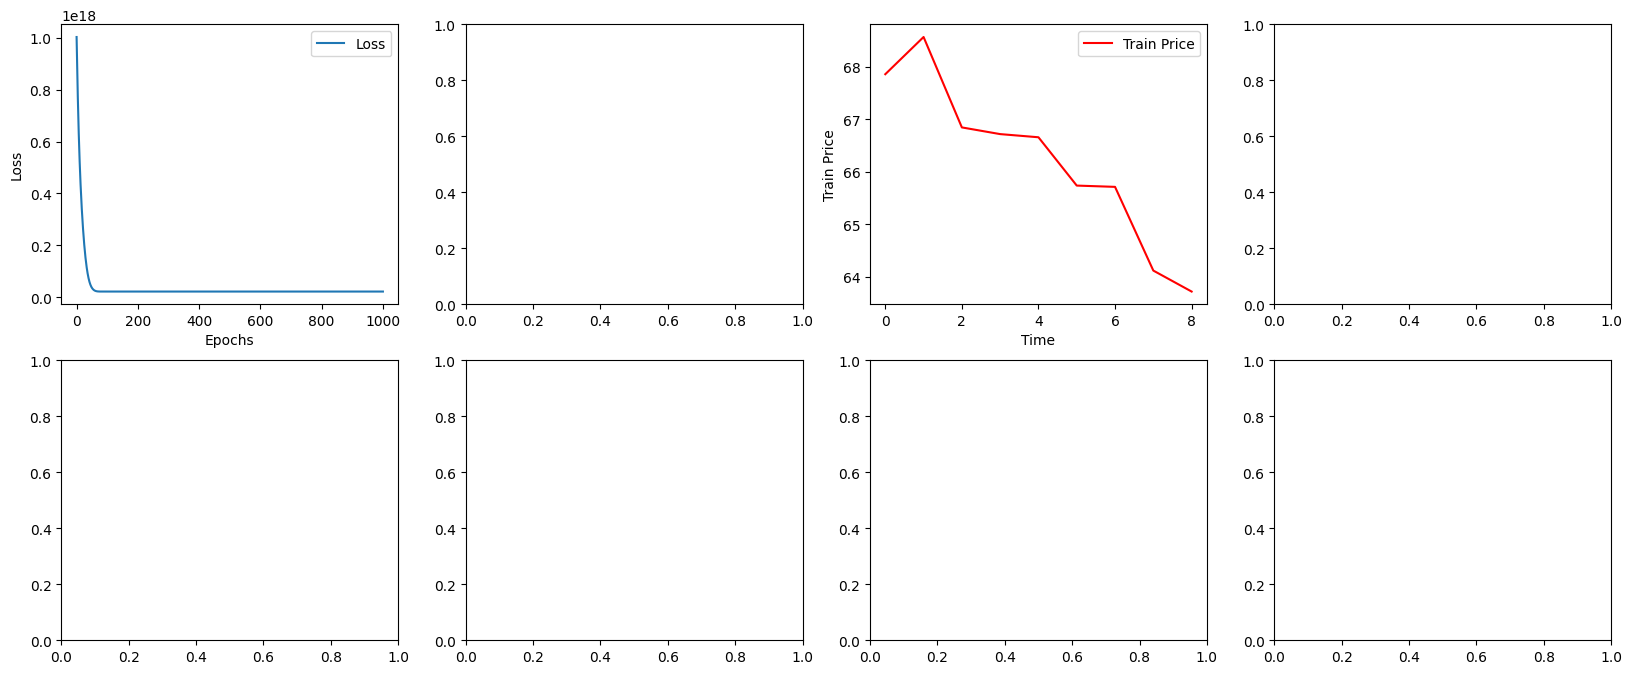

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
ax[0, 0].plot([e for e in range(len(model.loss_history))], model.loss_history, label="Loss")
ax[0, 0].set_ylabel('Loss')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].legend()

ax[0, 2].plot([e for e in range(len(model.X_train))], model.X_train[:, -1], label="Train Price", color='red')
ax[0, 2].set_ylabel('Train Price')
ax[0, 2].set_xlabel('Time')
ax[0, 2].legend()

ax[0, 3].plot([e for e in range(len(model.X_train))], model.predicted_train[:, -1], label="Predicted Train Price", color='green')
ax[0, 3].set_ylabel('Predicted Train Price')
ax[0, 3].set_xlabel('Time')
ax[0, 3].legend()

ax[1, 0].plot([e for e in range(len(model.X_test))], model.X_test[:, -1], label="Test Price", color='red')
ax[1, 0].set_ylabel('Tested Price')
ax[1, 0].set_xlabel('Time')
ax[1, 0].legend()

ax[1, 1].plot([e for e in range(len(model.X_test))], model.predicted_test[:, -1], label="Predicted Test Price", color='green')
ax[1, 1].set_ylabel('Predicted Tested Price')
ax[1, 1].set_xlabel('Time')
ax[1, 1].legend()

ax[0, 1].plot([e for e in range(len(model.r2_history))], model.r2_history, label="R2 Score", color='green')
ax[0, 1].set_ylabel('R2 Score')
ax[0, 1].set_xlabel('Time')
ax[0, 1].legend()